In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import glob

### Classifying waveforms into putative types

In [6]:
# Load the list of units used in a certain tensor
mytensorname = 'drifting_gratings_VISp_shiftdirs_p0.0005_32xp_N1261'
datadir = 'data'
AREA = 'VISp'
with open(f'{datadir}/{mytensorname}_significant_stims.pkl','rb') as f:
    significant_stims = pickle.load(f)

In [7]:
# Load the previously saved waveforms 
all_waveforms = []
for session_id in significant_stims:
    with open(f'data/{session_id}_waveforms.pkl','rb') as f:
        session_waveforms = pickle.load(f)
    assert AREA in session_waveforms
    
    session_uids = list(significant_stims[session_id].keys())
    
    for uid in session_uids:
        assert uid in session_waveforms[AREA]
        all_waveforms.append(session_waveforms[AREA][uid])
        
all_waveforms = np.array(all_waveforms)

In [8]:
SAMP_RATE = 30 # samples per ms
half_ms_len = int(round(.5 * SAMP_RATE))
slope_delta = int(round(SAMP_RATE/10.))

X = []#np.zeros((all_waveforms.shape[0],3))
X_is = []    

pos_spiking = []
triphasic = []
compound = []
for wi,wave in enumerate(all_waveforms):

    dp_val, dp_t = np.min(wave), np.argmin(wave)
    ahp_val, ahp_t = np.max(wave[dp_t+1:]),np.argmax(wave[dp_t+1:]) #peak after trough
    

    #NEW: additional types, based on
    #following https://physoc.onlinelibrary.wiley.com/doi/epdf/10.1113/JP280844
    # peak before trough?
    bhp_val = np.max(wave[:dp_t])
    
    if bhp_val > -dp_val:
        print(wi,'pos_spiking')
        pos_spiking.append(wi)
        continue
#     elif bhp_val > -.1*dp_val:
#         bhp_t = np.argmax(wave[:dp_t])
#         if (ahp_t - bhp_t)/SAMP_RATE > 1.:#peak-to-peak time > 1 ms
#             print(wi,'compound')
#             compound.append(wi)   
#             continue
#         print(wi,'triphasic')
#         triphasic.append(wi)
#         continue
        
    params = np.empty(3) # 3 columns for: after-hyper:depolar ratio, 
                            # trough to after-hyper time, slope 0.5 ms after trough

    params[0] = ahp_val/dp_val;
    params[1] = ahp_t/SAMP_RATE;

    slope_t = dp_t+half_ms_len
    interval = slope_t - slope_delta, slope_t + slope_delta
    assert dp_t < (wave.size-interval[1]-1)
    #slope at (dp_t + half_ms_len) == dp_t + 0.5 ms
    params[2] = (wave[interval[1]] - wave[interval[0]])/((interval[1] - interval[0])/SAMP_RATE)

    # time = np.arange(wave.size)/SAMP_RATE
    # plt.plot(time, wave, 'k', alpha=0.3)
    # plt.axvline(time[slope_t])
    # plt.axvline(time[interval[1]],ls='--')
    # plt.axvline(time[interval[0]],ls='--')
    X.append(params)
    X_is.append(wi)
X = np.array(X)

38 pos_spiking
47 pos_spiking
166 pos_spiking
261 pos_spiking
778 pos_spiking
832 pos_spiking
923 pos_spiking
959 pos_spiking
1030 pos_spiking
1117 pos_spiking
1142 pos_spiking


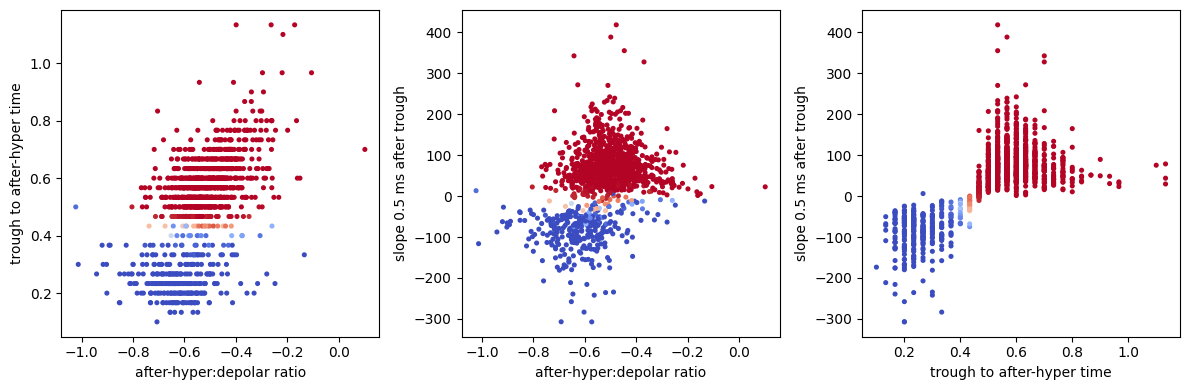

In [13]:
from sklearn.mixture import GaussianMixture
# fit a Gaussian Mixture Model with two components
clf = GaussianMixture(n_components=2, covariance_type="full",
                      weights_init=[.25,.75,], means_init=np.array([[ -0.63514055,   0.27272979, -86.10412454],
                                                                    [ -0.51590799,   0.58851188,  76.71094773]]))
clf.fit(X)
labels = clf.predict(X)
probs = clf.predict_proba(X)
f,axes = plt.subplots(1,3,figsize=(12,4))
axes[0].scatter(*X[:,[0,1]].T, s=7, c=probs[:,1],cmap='coolwarm')
axes[0].set(xlabel="after-hyper:depolar ratio", ylabel="trough to after-hyper time")
axes[1].scatter(*X[:,[0,2]].T, s=7, c=probs[:,1],cmap='coolwarm')
axes[1].set(xlabel="after-hyper:depolar ratio", ylabel="slope 0.5 ms after trough")
axes[2].scatter(*X[:,[1,2]].T, s=7, c=probs[:,1],cmap='coolwarm')
axes[2].set(xlabel="trough to after-hyper time", ylabel="slope 0.5 ms after trough")
f.tight_layout()
plt.show()

In [23]:
if len(pos_spiking) > 0: # label positive-spiking units as "2"
    full_labels = 2*np.ones(len(all_waveforms),dtype='int')
    full_labels[X_is] = labels
else:
    full_labels = labels.astype('int')

datadir = 'tensor-data'
np.save(f'{datadir}/{mytensorname}_types.npy', full_labels)

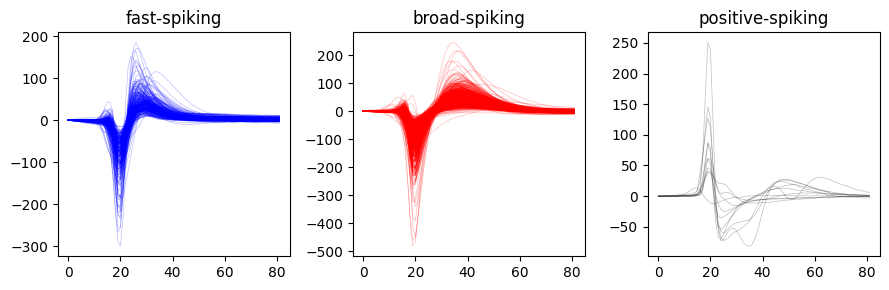

In [14]:
# show all waveforms belonging to each putative type
f, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(9,3))
time = np.arange(X.shape[1])/30.
ax0.plot(all_waveforms[X_is][labels==0].T,c='b',alpha=.25,lw=.5);
ax0.set_title('fast-spiking')
ax1.plot(all_waveforms[X_is][labels==1].T,c='r',alpha=.25,lw=.5);
ax1.set_title('broad-spiking')
ax2.plot(all_waveforms[pos_spiking].T,c='k',alpha=.25,lw=.5);
ax2.set_title('positive-spiking')
f.tight_layout()
plt.show()

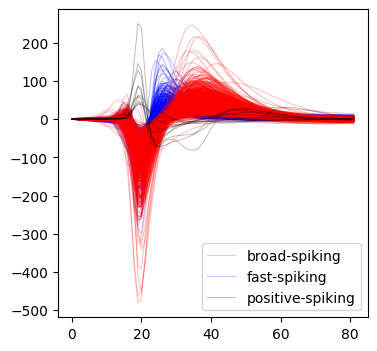

In [15]:
# plot all 3 put. types together
f, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(all_waveforms[X_is][labels==0].T,c='b',alpha=.25,lw=.75,label='fast-spiking');
ax.plot(all_waveforms[X_is][labels==1].T,c='r',alpha=.25,lw=.75,label='broad-spiking');
ax.plot(all_waveforms[pos_spiking].T,c='k',alpha=.25,lw=.75,label='positive-spiking');
handles, leglabels = plt.gca().get_legend_handles_labels()
leglabels, ids = np.unique(leglabels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, leglabels, loc='best')

plt.show()